# Enrichment Analysis

Enrichment analysis (EA) is a technique used to derive biological insight from lists of significantly altered genes. The list of genes can be obtained from Differential Expression (DE) analysis or users' interest. The EA methods rely on the knowledge databases (e.g. KEGG and GO) to identify biological pathways or terms that are enriched in a gene list more than would be expected by chance. The outcome of the EA would be the in-depth and contextualized findings to help understand the mechanisms of disease, genes and proteins associated with the etiology of a specific disease or drug target.

Over more than a decade, there are over 50 methods have been developed for EA. In this module, we will focus on pathway analysis using three popular methods including Over Representation Analysis (ORA), Fast Gene Set Enrichment Analysis (FGSEA), and Gene Set Analysis (GSA).

## Learning Objectives:
1. Data preparation
2. Perform enrichment analysis using ORA, FGSEA and GSA
3. Visualize and interpret the outputs

In [1]:
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-1.html" width=100% height=250></iframe>')

## Gene Mapping
In this module, we will use the DE genes with statistic generated in the [**submodule 02** ](./Module02-DE_Analysis.ipynb) using `limma` R package. We can use the following command to load the DE analysis result.

In [2]:
# Load previously saved data
DE.df <- readRDS("./data/DE_genes.rds")
rownames(DE.df) <- DE.df$PROBEID
head(DE.df)

,PROBEID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
222178_s_at,222178_s_at,-0.4473780,0.3653633,-73.01106,4.019112e-55,2.197450e-50,81.05538
224687_at,224687_at,-4.1431631,2.2572347,-48.92036,5.489424e-46,1.500671e-41,74.18354
207488_at,207488_at,-0.4017530,0.6243144,-39.29933,4.735684e-41,8.630785e-37,68.83493
239226_at,239226_at,0.4483302,1.3245501,28.36499,7.626558e-34,1.042455e-29,58.84908
234109_x_at,234109_x_at,-0.2289726,0.7508256,-27.67010,2.635337e-33,2.881741e-29,58.00438
212833_at,212833_at,-2.5976592,1.7308944,-24.01172,2.914912e-30,2.656213e-26,52.99567


We can see that the genes are saved with probe IDs, we need to convert them into gene symbols so that they can be analyzed using the enrichment analysis method later in this module. We will use the same approach presented in the [**submodule 01** ](./Module01-GEO_Data_Processing.ipynb) with `hgu133plus2.db` and `AnnotationDbi` databases.

In [3]:
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4.html" width=100% height=250></iframe>')

In [4]:
# Load the databases
suppressMessages({
  library(hgu133plus2.db)
  library(AnnotationDbi)
})

Then, we can retrieve vector of probe IDs to perform gene symbol mapping using the following command:

In [5]:
probeIDs = DE.df$PROBEID
# Map probe IDs to their symbols
suppressMessages({
annotLookup <- AnnotationDbi::select(hgu133plus2.db, keys = probeIDs, columns = c('PROBEID','GENENAME','SYMBOL'))
})
# View the first few genes in the mapping table
head(annotLookup)

,PROBEID,GENENAME,SYMBOL
,<chr>,<chr>,<chr>
1,222178_s_at,NA,NA
2,224687_at,ankyrin repeat and IBR domain containing 1,ANKIB1
3,207488_at,NA,NA
4,239226_at,NA,NA
5,234109_x_at,one cut homeobox 3,ONECUT3
6,212833_at,solute carrier family 25 member 46,SLC25A46


Now, we can merge DE data frame with annotation table by the `PROBEID` and remove NA gene symbols using the following command:

In [6]:
DE.df = merge(annotLookup, DE.df, by="PROBEID")

In [7]:
# Remove NA gene symbol
DE.df = DE.df[!is.na(DE.df$SYMBOL), ]
# Remove duplicated genes
DE.df = DE.df[!duplicated(DE.df$SYMBOL, fromLast=FALSE),]
head(DE.df)

,PROBEID,GENENAME,SYMBOL,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1007_s_at,discoidin domain receptor tyrosine kinase 1,DDR1,-0.23858465,1.0967772,-2.08257585,0.04210211,0.2531265,-4.284228
2,1053_at,replication factor C subunit 2,RFC2,0.05830367,0.9657758,1.42311356,0.16052793,0.4674726,-5.359907
3,117_at,heat shock protein family A (Hsp70) member 6,HSPA6,-0.01138494,1.1501582,-0.08100885,0.93573821,0.9861536,-6.337785
4,121_at,paired box 8,PAX8,0.02301084,1.0581847,0.87166663,0.38729816,0.7236528,-5.968512
5,1255_g_at,guanylate cyclase activator 1A,GUCA1A,0.36999950,1.4080351,1.78615022,0.07976123,0.3351480,-4.812134
6,1294_at,ubiquitin like modifier activating enzyme 7,UBA7,-0.11221434,1.0859983,-1.61593670,0.11200995,0.3925252,-5.082923


As a result, we obtained the new DE table with two more columns containing gene names and gene symbols. The use of this DE table can be varied based on the selected enrichment analysis tools.

## Enrichment Analysis Using Over-Representation Analysis
Over-representation analysis (ORA) is a statistical method that determines whether genes from a pre-defined gene set of a specific GO term or KEGG pathway are presented more than would be expected (over-represented) in a subset of your data. In our learning module, this subset refers to the list of DE genes generated from the `limma` method. For each gene set, an enrichment *p-value* is calculated using the Binomial distribution, Hypergeometric distribution, the Fisher exact test, or the Chi-square test.  The hypergeometric distribution is a popular approach used to calculate enrichment p-value. The formula can be presented as follows:

$$
     P(X\geq x) = 1 - P(X \leq x-1) = 1 - \sum\limits_{i=0}^{x-1}\frac{\hphantom{}{M \choose i }{N - M \choose n-i}}{N \choose n}
$$

where *N* is the number of background genes (all genes presented in the expression matrix), *n* is the number of “interesting” genes (DE genes), *M* is the number of genes that are annotated to a particular gene set *S* (list of genes in a specific KEGG pathway or GO term), and *x* is the number of “interesting” genes that are annotated to *S* (genes presented in DE genes list and a specific KEGG pathway or GO term).

For example, suppose we have an expression matrix with 20,000 genes, of which 500 are differently expressed. Also, suppose that 100 of the 20,000 genes are annotated to a particular gene set S. Of these 100 genes, 20 are members of the DE genes list. The probability that 20 or more (up to 100) genes annotated to S are in the DE genes list by chance is given by

$$
P(X\geq 20) = 1 - P(X \leq 19) = 1-\sum \limits_{i=0}^{19}\frac{\hphantom{}{100 \choose i}{20000 - 100 \choose 500-i}}{20000 \choose 500} = 5.26 \times 10^{-13}
$$

The *p-value* indicates that it is very rare to observe 20 of the 100 genes from this set are in the DE genes list by chance.

In [8]:
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-2.html" width=100% height=250></iframe>')

### Data preparation
To conduct enrichment analysis using ORA, there are several input data that we need to prepare. First, we need to select a set of genes that
are significantly altered (*p-value < 0.05*) in the DE genes generated from the `limma` method.

In [10]:
# Selecting a list of significant DE genes
DEGenes <- DE.df[DE.df$adj.P.Val <= 0.05, ]
# Select genes with symbol
DEGenes <- DEGenes$SYMBOL

Next, we need to define a list of background genes. In this analysis, they are all the genes generated from the DE analysis.

In [11]:
#Defining background genes
backgroundSet <- DE.df$SYMBOL

Then, we need to obtain a list of geneset from knowledge databases such as GO and KEGG. In this learning module, the geneset will be retrieved from
the *.gmt* files that were processed from the [**submodule 03**](./Module03-Gene_Set_and_Pathway.ipynb). To load the geneset, we will use the `gmt2geneset` function below:

In [12]:
# install tidyverse
suppressWarnings({
  install.packages("tidyverse")
})

Installing package into 'C:/Users/ASUS/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'tidyverse' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ASUS\AppData\Local\Temp\RtmpC4cJMm\downloaded_packages


In [13]:
# Loading tidyverse library that provides a function to read the .gmt file
suppressMessages({
  library(tidyverse)
})

Here, we also write a function to perform over-representation analysis based on the hyper-geometric testing formula presented above. The `ORA` method will perform
hyper-geometric testing for each geneset obtained from GO or KEGG using the function `phyper` available for the `stats` R base package. The output of the `ORA` function is a table that contains a column of terms or pathway names and a column of *p-value*.

In [14]:
# A customized function to parse a gmt file to a list of genesets
gmt2geneset <- function(path) {
  # Read the GMT file and create a list of gene sets
  genesets <- read_tsv(path, col_names = F) %>% apply(MARGIN = 1, function(r) {
    # Extract unique genes from the current row (excluding the first two elements)
    genes = unique(r[-(1:2)]) 
    # Create a list for each gene set with ID, description, and non-NA genes
    list(
      id = r[1],
      description = r[2],
      genes = genes[!is.na(genes)]
    )
  })
  # Extract the gene sets from the list and convert gene vectors to character
  gs <- lapply(genesets, function(g) g$genes %>% as.character())
  # Set names for the gene sets based on their descriptions
  names(gs) <- lapply(genesets, function(g) g$description)
  # Return the resulting list of gene sets
  gs
}


**Arguments** of the `ORA` function:

- `geneset` (*list*): A list of gene sets to be analyzed.
- `DEGenes` (*vector*): A vector of differentially expressed genes.
- `backgroundSet` (*vector*): A set of genes representing the background.
- `DE.df` (*data.frame*): A data frame containing information about differentially expressed genes.

In [15]:
# Over-Representation Analysis (ORA) Function
ORA <- function(geneset, DEGenes, backgroundSet, DE.df) {
  # Initialize an empty vector to store the results of the analysis
  res <- sapply(geneset, function(gs) {
    # Count the number of differentially expressed genes in the current gene set (gs)
    wBallDraw <- intersect(gs, DEGenes) %>% length() - 1
    # Check for a potential issue with the intersection count being negative
    if (wBallDraw < 0) return(1)
    # Total number of differentially expressed genes
    wBall <- length(DEGenes)
    # Remaining genes in the background set
    bBall <- nrow(DE.df) - length(DEGenes)
    # Number of genes in the current gene set that are in the background set
    ballDraw <- length(intersect(gs, backgroundSet))
    # Calculate the hypergeometric probability using the phyper function
    hypergeo_prob <- phyper(wBallDraw, wBall, bBall, ballDraw)
    # Calculate the complementary probability (1 - hypergeometric probability)
    1 - hypergeo_prob
  })
  # Return the vector of results (p-values)
  res
}


### Enrichment analysis using ORA and GO terms
In this section, we will perform ORA using genesets obtained from the GO database and the function `ORA` defined above. The detailed code is presented below:

In [16]:
# Loading geneset from GO database
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/GO_terms.gmt")})})
# Perform ORA
res.ORA <- ORA(geneset = geneset, DEGenes = DEGenes, backgroundSet = backgroundSet, DE.df = DE.df)
# Save the result to a table where the first column is GO term name and the second column is the p-value
res.df <- data.frame(
  GOterms = names(res.ORA),
  pvalue = res.ORA
)
# Order the table based on the p-value
res.df <- res.df[order(res.df$pvalue),]
# View the most significant GO terms
head(res.df)

,GOterms,pvalue
,<chr>,<dbl>
"mitochondrial electron transport, cytochrome c to oxygen","mitochondrial electron transport, cytochrome c to oxygen",0.0001704211
aerobic electron transport chain,aerobic electron transport chain,0.0004551632
respiratory electron transport chain,respiratory electron transport chain,0.0004551632
ATP synthesis coupled electron transport,ATP synthesis coupled electron transport,0.0004551632
mitochondrial ATP synthesis coupled electron transport,mitochondrial ATP synthesis coupled electron transport,0.0004551632
inner dynein arm assembly,inner dynein arm assembly,0.0010416338


From the result table, we might conclude that the pathways shown are key components of the disease in study.

### Enrichment analysis using ORA and KEGG pathways

We will perform the same steps as we did above for the GO terms.

In [17]:
# Loading the KEGG pathways
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/KEGG_pathways.gmt")})})

In [18]:
# Perform Hyper-geometric testing
res.ORA <- ORA(geneset = geneset, DEGenes = DEGenes, backgroundSet = backgroundSet, DE.df = DE.df)
# Save the results to a data frame
res.df <- data.frame(
  pathways = names(res.ORA),
  pvalue = res.ORA
)

res.df <- res.df[order(res.df$pvalue),]
head(res.df)

,pathways,pvalue
,<chr>,<dbl>
Purine metabolism - Homo sapiens (human),Purine metabolism - Homo sapiens (human),0.03779064
AMPK signaling pathway - Homo sapiens (human),AMPK signaling pathway - Homo sapiens (human),0.03926858
Complement and coagulation cascades - Homo sapiens (human),Complement and coagulation cascades - Homo sapiens (human),0.03926858
Primary immunodeficiency - Homo sapiens (human),Primary immunodeficiency - Homo sapiens (human),0.06601342
Proteasome - Homo sapiens (human),Proteasome - Homo sapiens (human),0.09258568
Virion - Herpesvirus - Homo sapiens (human),Virion - Herpesvirus - Homo sapiens (human),0.09772411


## Enrichment Analysis using FGSEA

This submodule describes `FGSEA`, one of the methods for evaluating pathway enrichment in transcriptional data and it stands for Fast preranked Gene Set Enrichment Analysis (GSEA). `FGSEA` quickly calculates arbitrarily low GSEA P-values for a collection of gene sets and is based on an algorithm that allows  it to make more permutations and get accurate *p-values*.
It extends the GSEA algorithm which calculates the enrichment score (the degree to which a set S is over-represented at the top or bottom of the ranked list L), estimates the p-value of the Enrichment Score using a permutation test and adjusts the estimated significance level to account for multiple hypotheses in addition to calculating the q-values for FDR control. Typically, GSEA requires inputs of a list of gene sets (GO term or pathway with a set of genes), a vector DE genes with statistic. In addition, users can limit the number of terms or pathways of interest by adjusting the `minSize` and `maxSize` parameters. The code to install and load the FGSEA R package is shown below:

In [19]:
# To perform enrichment analysis using FGSEA, we first install the fgsea package
suppressMessages({if (!require("BiocManager", quietly = TRUE))
        install.packages("BiocManager")
  suppressWarnings(BiocManager::install("fgsea", update = F))
})

In [20]:
# Loading the package
suppressPackageStartupMessages({
  library("fgsea")
})

In [21]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-3.html" width=100% height=250></iframe>')

Next, we need to prepare a vector of DE genes with its statistic.

In [22]:
# Get the gene list and their statistic from DE results
stats = DE.df$adj.P.Val
names(stats) = DE.df$SYMBOL
head(stats)

DDR1      RFC2     HSPA6      PAX8    GUCA1A      UBA7 
0.2531265 0.4674726 0.9861536 0.7236528 0.3351480 0.3925252

### Enrichment analysis using FGSEA and GO terms

The package `fgsea` has its own function named `gmtPathways` to load the genesets from the `gmt` file. It is recommended to use this function for compatibility. We can load the GO terms geneset and view the first five GO terms with associated genes using the following command:

In [23]:
# Load the pathways into a named list
GO_term_hallmark <- gmtPathways("./data/GO_terms.gmt")
# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(GO_term_hallmark, head)
tmp[1:5]

$`GO:0000002`
[1] "AKT3"   "DNA2"   "DNAJA3" "ENDOG"  "FLCN"   "LIG3"  

$`GO:0000003`
[1] "A1CF"  "A2M"   "AAAS"  "ABAT"  "ABCC8" "ABHD2"

$`GO:0000012`
[1] "APLF"  "APTX"  "ERCC6" "ERCC8" "LIG4"  "PARP1"

$`GO:0000018`
[1] "ABL1"   "ACTB"   "ACTL6A" "ACTR2"  "ALYREF" "ANKLE1"

$`GO:0000022`
[1] "AURKB"  "AURKC"  "BIRC5"  "CDCA8"  "INCENP" "KIF23"

Running the FGSEA can be done by calling the `fgsea` with two required inputs that we created from the two previous steps.

Used **arguments** of the `fgsea` function:
- `pathways` (*list*): List of gene sets to check.
- `stats` (*numeric vector*): Named vector of gene-level stats. Names should be the same as in 'pathways'.

In [24]:
# Running fgsea
suppressWarnings(fgseaRes <- fgsea(pathways = GO_term_hallmark,
                  stats = stats
                  ))

The output of the FGSEA method is a table where rows are GO terms IDs or pathway IDs. The columns are *p-values*, *adjusted p-values*, *Enrichment Score*, etc.

In [29]:
head(fgseaRes[order(pval), ][, -8])

pathway,pval,padj,log2err,ES,NES,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
GO:0006122,8.953719e-06,0.04648262,0.5933255,-0.7106070,-2.576761,11
GO:0050907,1.940800e-05,0.04648262,0.5756103,0.3788597,1.572075,132
GO:0060390,2.028628e-05,0.04648262,0.5756103,0.4911948,1.855808,46
GO:0007606,8.178477e-05,0.12802215,0.5384341,0.3450003,1.465727,182
GO:0050911,1.167654e-04,0.12802215,0.5384341,0.3929034,1.584887,94
GO:0030850,1.235671e-04,0.12802215,0.5188481,0.4547892,1.738423,51


From the result table, we can select top five up regulated GO terms and top five down regulated GO terms. Then we can plot them using the built-in function `plotGseaTable`

Used **arguments** of the `plotGseaTable` function:

- `pathways` (*list*): Pathways to plot table.
- `stats` (*data.frame*): Gene-level stats.
- `fgseaRes` (*data.frame*): Table with fgsea results.
- `gseaParam` (*numeric*): GSEA-like parameter. Adjusts displayed statistic values, values closer to 0 flatten plots. Default = 1, value of 0.5 is a good choice too.

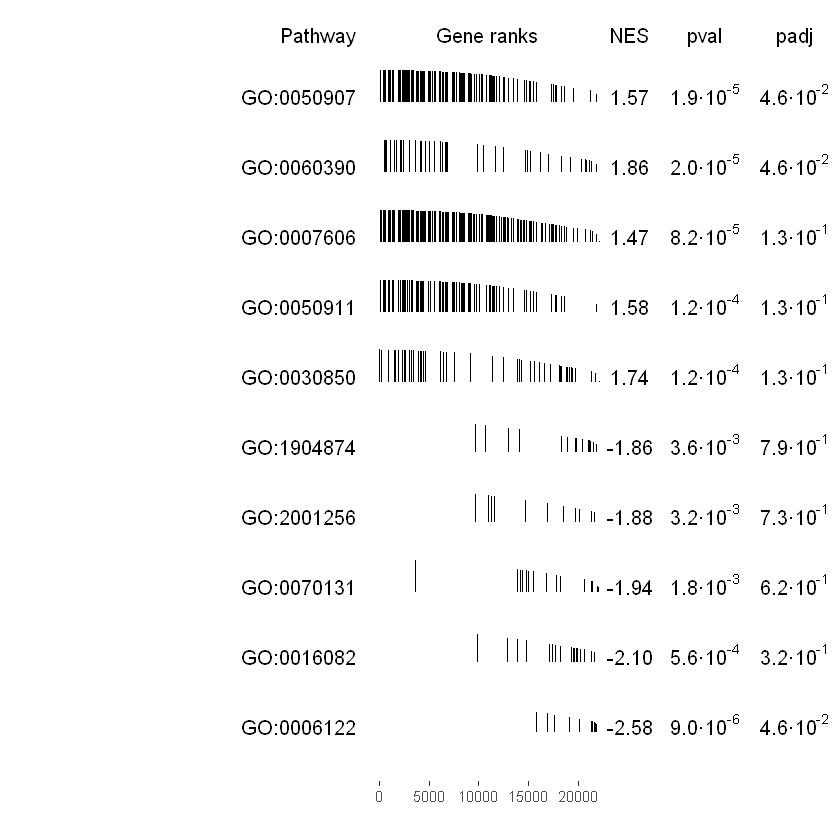

In [30]:
topGOUp <- fgseaRes[ES > 0][head(order(pval), n=5), pathway]
topGODown <- fgseaRes[ES < 0][head(order(pval), n=5), pathway]
topGO <- c(topGOUp, rev(topGODown))
# create the plot
plotGseaTable(pathways = GO_term_hallmark[topGO], stats = stats, fgseaRes = fgseaRes,
              gseaParam = 0.5)

### Enrichment analysis using FGSEA and KEGG pathways
We can perform enrichment analysis using FGSEA with KEGG pathway using the same procedure mentioned above. The only thing we need to change is the
list of genesets that are available in the KEGG database.

In [31]:
# Load the pathways into a named list
KEGG_hallmark <- gmtPathways("./data/KEGG_pathways.gmt")
# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(KEGG_hallmark, head)
tmp[1:5]

$hsa00010
[1] "HK3"   "HK1"   "HK2"   "HKDC1" "GCK"   "GPI"  

$hsa00020
[1] "CS"   "ACLY" "ACO2" "ACO1" "IDH1" "IDH2"

$hsa00030
[1] "GPI"  "G6PD" "PGLS" "H6PD" "PGD"  "RPE" 

$hsa00040
[1] "GUSB"    "KL"      "UGT2A1"  "UGT2A3"  "UGT2B17" "UGT2B11"

$hsa00051
[1] "MPI"   "PMM2"  "PMM1"  "GMPPB" "GMPPA" "GMDS"

In [32]:
# Running fgsea
suppressWarnings(fgseaRes <- fgsea(pathways = KEGG_hallmark,
                  stats    = stats))

In [33]:
head(fgseaRes[order(pval), ][, -8])

pathway,pval,padj,log2err,ES,NES,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
hsa04060,3.181473e-06,0.001081701,0.6272567,0.3356103,1.457547,293
hsa04740,1.058477e-03,0.179941158,0.4550599,0.3409007,1.414354,132
hsa04061,2.497384e-03,0.283036864,0.4317077,0.3528680,1.439385,98
hsa04080,7.547702e-03,0.639029354,0.4070179,0.2778361,1.214380,358
hsa00500,9.397490e-03,0.639029354,0.3807304,0.4184500,1.539228,36
hsa05340,1.195356e-02,0.677368355,0.3807304,0.4011639,1.480033,37


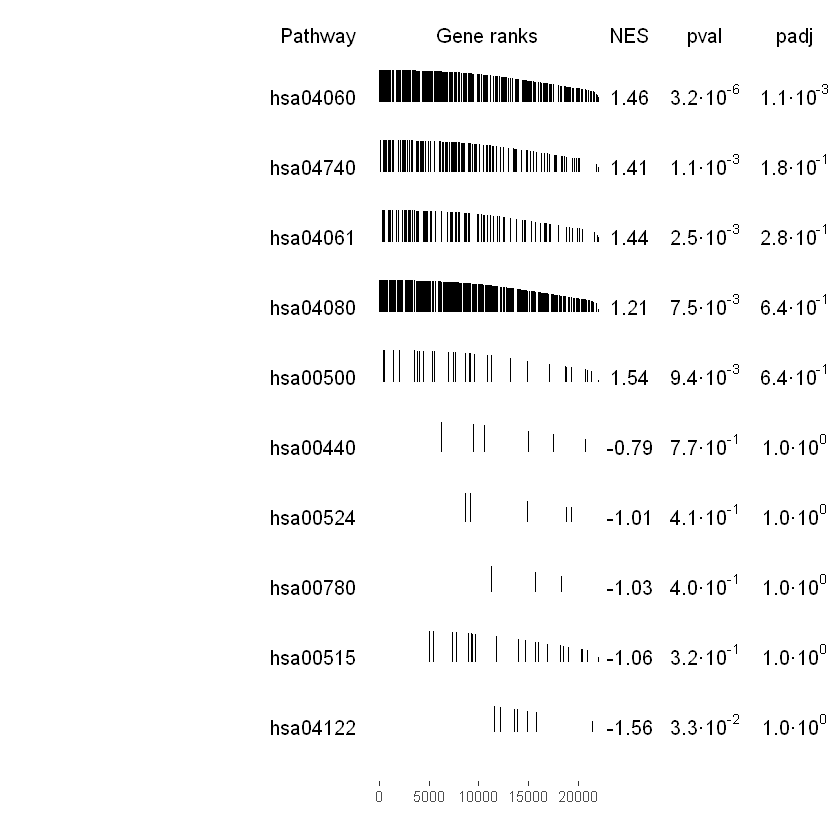

In [34]:
# select the top five up-regulated pathways 
topPathwaysUp <- fgseaRes[ES > 0][head(order(pval), n=5), pathway]
# select the top five down-regulated pathways 
topPathwaysDown <- fgseaRes[ES < 0][head(order(pval), n=5), pathway]
# concatenate them for visualization
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
#Viewing the 5 most significantly up-regulated and down-regulated pathways each with the FGSEA internal plot function
plotGseaTable(pathways = KEGG_hallmark[topPathways], stats = stats, fgseaRes = fgseaRes,
              gseaParam = 0.5)

## Gene Set Enrichment Analysis using GSA

Gene Set Analysis (GSA), an Enrichment Analysis, is a method that is commonly used to summarize high-dimensional gene expression data sets into sets according to their biological relevance. GSA takes the ranked gene lists from the initial stage of a gene expression analysis and aggregates the genes into sets based on shared biological or functional properties as specified by a reference knowledge base. Such databases often contain phenotype associations, molecular interactions and regulation and are referenced in the analysis of the resultant gene sets to find the relevance of the gene properties to the phenotype of interest.

In [31]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-4.html" width=100% height=250></iframe>')

### Data preparation
The GSA method is freely available as standalone package in CRAN repository. We can use the following code to install the package.

In [35]:
# Install GSA from CRAN
suppressMessages({if (!require("GSA"))
        suppressWarnings(install.packages("GSA"))
})

In [36]:
suppressMessages({
  library(GSA)
})

The GSA method requires an expression matrix, a numeric vector containing the class of each sample and a vector of genes the inputs. We can easily get those inputs by loading the data that we processed in the [**Module 01** ](./Module01-GEO_Data_Processing.ipynb).

In [37]:
# Loading expression data with groups
data <- readRDS("./data/GSE48350.rds")
expression_data <- data$expression_data
norm_expression_data <- data$norm_expression_data
groups <- data$groups

We can also use the sample approach available in the [**Module 01** ](./Module01-GEO_Data_Processing.ipynb) to map the probe IDs to gene symbols. The step-by-step coding instruction is shown below:

In [38]:
# Get the probe IDs
expression_data$PROBEID <- rownames(expression_data)
probeIDs <- rownames(expression_data)
# Perform gene mapping
suppressMessages({
  annotLookup <- AnnotationDbi::select(hgu133plus2.db, keys = probeIDs, columns = c('PROBEID', 'GENENAME', 'SYMBOL'))
})
# Merge DE result  data frame with annotation table
new_expression_data = merge(annotLookup, expression_data, by="PROBEID")
# Remove NA value
new_expression_data <- new_expression_data[!is.na(new_expression_data$SYMBOL),]
# Remove duplicated genes symbol
new_expression_data <-  new_expression_data[!duplicated(new_expression_data$SYMBOL,fromLast=FALSE),]
rownames(new_expression_data) <- new_expression_data$SYMBOL
# Drop PROBEID, GENENAME, and SYMBOL columns
new_expression_data <- new_expression_data[,-c(1:3)]
genenames= rownames(new_expression_data)

### GSA Enrichment Analysis using GO Terms
Using data obtained from the previous step, we can run the GSA method by calling the function `GSA`. We can reuse `GO_term_hallmark` and `KEGG_hallmark` loaded in FGSEA to perform analysis. The code details are shown below:

Used **arguments** of the `GSA` function:
- `x` (*matrix*): Data x: p by n matrix of features (expression values), one observation per column (missing values allowed); y: n-vector of outcome measurements.
- `y` (*numeric vector*): Vector of response values: 1,2 for two class problem, or 1,2,3 ... for multiclass problem, or real numbers for quantitative or survival problems
- `genesets` (*list*): Gene set collection.
- `genenames` (*vector*): Vector of genenames in expression dataset.
- `resp.type` (*character*): Problem type: "quantitative" for a continuous parameter; "Two class unpaired" ; "Survival" for censored survival outcome; "Multiclass" : more than 2 groups, coded 1,2,3...; "Two class paired" for paired outcomes, coded -1,1 (first pair), -2,2 (second pair), etc.
- `nperms` (*numeric*): Number of permutations used to estimate false discovery rates.
- `random.seed` (*integer*): Optional initial seed for random number generator.

<div class="alert alert-block alert-danger">
    <i class="fa fa-exclamation-circle" aria-hidden="true"></i>
    <b>Alert: </b>  Please note that the outputs generated from GSA can be varied depending on R environments and software versions. Especially, when the users run the scripts using User-managed Notebooks instances which have a preinstalled suite of packages.
</div>

In [41]:
# Getting 
genesets = GO_term_hallmark
GSA.obj<-GSA(x = as.matrix(new_expression_data), y = as.numeric(groups$groups), genenames = genenames, genesets = genesets, resp.type = "Two class unpaired", nperms = 100, random.seed = 1)

perm= 10 / 100 
perm= 20 / 100 
perm= 30 / 100 
perm= 40 / 100 
perm= 50 / 100 
perm= 60 / 100 
perm= 70 / 100 
perm= 80 / 100 
perm= 90 / 100 
perm= 100 / 100 


Used **arguments** of the `GSA.listsets` method:

- `GSA.obj` (*GSA object*): Object returned by GSA function.
- `geneset.names` (*vector*): Optional vector of names for the gene sets.
- `FDRcut` (*numeric*): False discovery rate cutpoint for listed sets. A value of 1 will cause all sets to be listed.

In [43]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj = GSA.obj, geneset.names = names(genesets), FDRcut = .5)

A table of the negative gene sets. “Negative” means that lower expression of most genes in the gene set correlates with higher values of the phenotype y. E.g., for two classes coded 1,2, lower expression correlates with class 2.

In [44]:
neg.table <-res$negative
head(neg.table)

Gene_set,Gene_set_name,Score,p-value,FDR
57,GO:0000422,-0.4838,0,0
641,GO:0006123,-1.3695,0,0
893,GO:0006851,-0.802,0,0
925,GO:0006906,-0.4592,0,0
976,GO:0007007,-1.2636,0,0
987,GO:0007029,-0.5442,0,0


A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y.

In [45]:
pos.table <-res$positive
head(pos.table)

Gene_set,Gene_set_name,Score,p-value,FDR
1681,GO:0014037,0.7351,0,0
1682,GO:0014044,0.9529,0,0
1713,GO:0014855,0.3543,0,0
1729,GO:0014912,0.6334,0,0
1877,GO:0017145,0.5308,0,0
2009,GO:0021533,0.596,0,0


Used **arguments** of the `GSA.genescores` method:
- `geneset.number` (*numeric*): Number indicating which gene set is to examined.
- `genesets` (*list*): The gene set collection.
- `GSA.obj` (*GSA obj*ect): Object returned by function GSA.
- `genenames` (*vector*): Vector of gene names for gene in expression dataset.


In [52]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(geneset.number = 10, genesets = genesets, GSA.obj = GSA.obj, genenames = genenames)

Gene,Score
SH3GLB1,2.729
IFT88,2.491
MTMR3,2.271
TP53INP1,2.134
ATG16L2,1.973
ATG2B,1.944
ATG14,1.935
ATG7,1.597
STING1,1.457
MAP1LC3B2,1.385


Used **argument** of `GSA.plot` method:
- `GSA.obj` (*GSA object*): Object returned by GSA function.
- `fac` (*numeric*): value for jittering points in plot ("factor" in called to jitter()).
- `FDRcut` (*numeric*): False discovery rate cutpoint for sets to be plotted. A value of 1 (the default) will cause all sets to be plotted.plotted



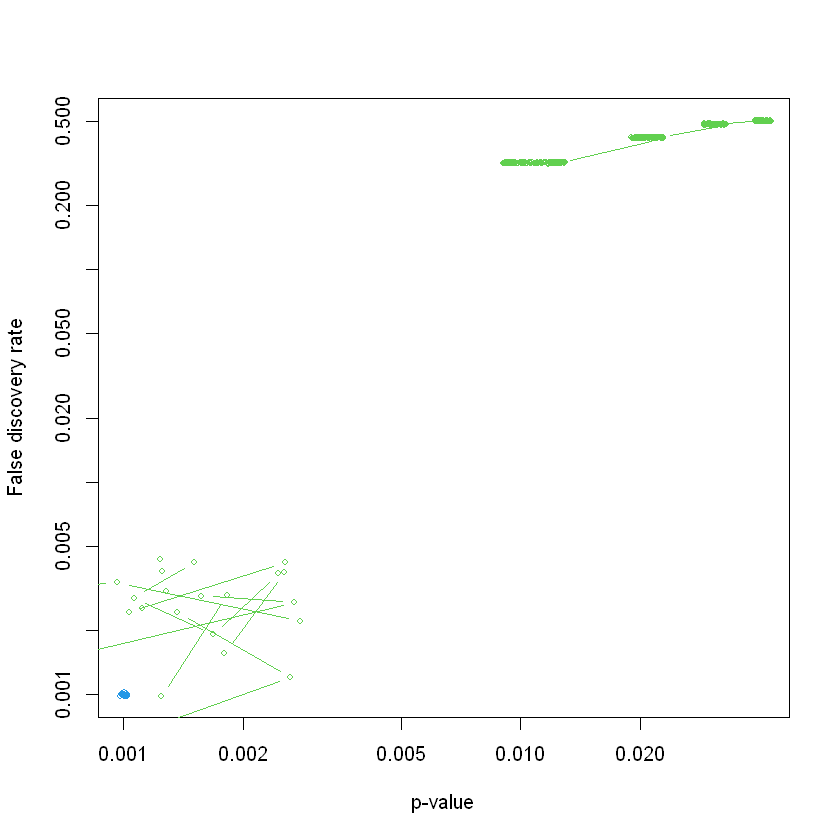

In [53]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
suppressWarnings(GSA.plot(GSA.obj, fac=1, FDRcut = 0.5))

### GSA Enrichment analysis using KEGG pathways
We can use the same procedure to per enrichment analysis with the KEGG pathway. All the codes are similar but `genesets` are assigned from `KEGG_hallmark`. The code is shown below.

In [54]:
genesets = KEGG_hallmark
GSA.obj<-GSA(x = as.matrix(new_expression_data), y = as.numeric(groups$groups), genenames=genenames, genesets=genesets, resp.type="Two class unpaired", nperms=100, random.seed=1)

perm= 10 / 100 
perm= 20 / 100 
perm= 30 / 100 
perm= 40 / 100 
perm= 50 / 100 
perm= 60 / 100 
perm= 70 / 100 
perm= 80 / 100 
perm= 90 / 100 
perm= 100 / 100 


In [55]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj = GSA.obj, geneset.names = names(genesets), FDRcut = .5)

A table of the negative gene sets. "Negative" means that lower expression of most genes in the gene set correlates with higher values of the phenotype y. E.g., for two classes coded 1,2, lower expression correlates with class 2.

In [56]:
neg.table <- res$negative
head(neg.table)

Gene_set,Gene_set_name,Score,p-value,FDR
214,hsa04260,-0.6732,0,0
239,hsa04723,-0.703,0,0
15,hsa00190,-1.0477,0.01,0.2485
89,hsa00970,-0.8305,0.01,0.2485
252,hsa04714,-0.523,0.01,0.2485
318,hsa05010,-0.497,0.01,0.2485


A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y. See "negative" above for more info.

In [57]:
pos.table <- res$positive
head(pos.table)

Gene_set,Gene_set_name,Score,p-value,FDR
7,hsa00053,0.7726,0,0
164,hsa04520,0.474,0,0
169,hsa04810,0.2231,0,0


In [58]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(geneset.number = 10, genesets = genesets, GSA.obj = GSA.obj, genenames = genenames)

Gene,Score
ALDH9A1,2.707
ACSS1,2.612
ADH1B,1.513
GRHPR,0.854
ALDH2,0.768
ALDH3A2,0.726
ALDH7A1,0.64
ACACB,0.455
ADH6,0.346
LDHAL6B,0.22


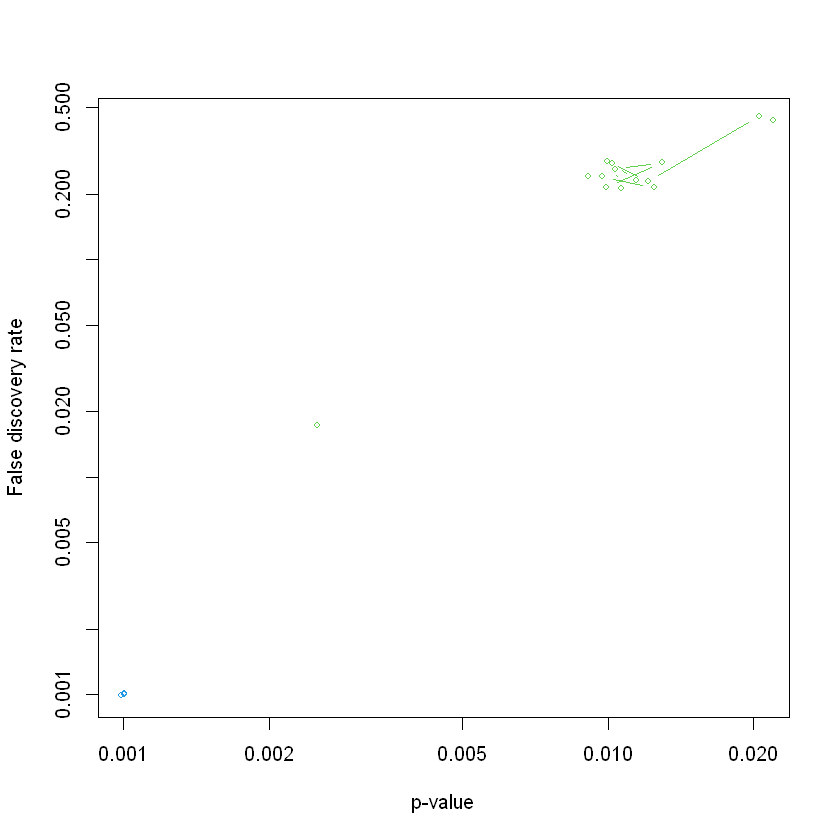

In [59]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
suppressWarnings(GSA.plot(GSA.obj, fac=1, FDRcut = 0.5))


The next submodule will go indepth about meta analysis.

In [60]:
sessionInfo()

R version 4.3.2 (2023-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19045)

Matrix products: default


locale:
[1] LC_COLLATE=English_United States.utf8 
[2] LC_CTYPE=English_United States.utf8   
[3] LC_MONETARY=English_United States.utf8
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.utf8    

time zone: America/Chicago
tzcode source: internal

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] GSA_1.03.2            fgsea_1.28.0          BiocManager_1.30.22  
 [4] lubridate_1.9.3       forcats_1.0.0         stringr_1.5.1        
 [7] dplyr_1.1.4           purrr_1.0.2           readr_2.1.4          
[10] tidyr_1.3.0           tibble_3.2.1          ggplot2_3.4.4        
[13] tidyverse_2.0.0       hgu133plus2.db_3.13.0 org.Hs.eg.db_3.18.0  
[16] AnnotationDbi_1.64.1  IRanges_2.36.0        S4Vectors_0.40.2     
[19] Biobase